Setup & Imports
You'll need to log into huggingface and accept the terms of the licence for this model - see the model card for details. And when you first run this notebook you need to uncomment the following two cells to install the requirements and log in to huggingface with an access token.

In [1]:
!pip install faiss-cpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 54.6 MB/s eta 0:00:00


In [2]:
!pip install -q --upgrade transformers diffusers ftfy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 69.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.9/934.9 kB 60.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 78.4 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
! mkdir "/root/.huggingface"

In [6]:
! cp "drive/MyDrive/.huggingface/token" /root/.huggingface/token

In [7]:
from base64 import b64encode

import numpy
import os
import torch

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
import torch.nn.functional as F
from transformers import logging

torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
torch.cuda.is_available()

True

In [9]:
# Load the pre-trained ViT model
model = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')

# Define preprocessing pipeline for images
transform = tfms.Compose([
    tfms.Resize(256),
    tfms.CenterCrop(224),
    tfms.ToTensor(),
    tfms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


Downloading: "https://github.com/facebookresearch/dino/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/dino/dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dino_deitsmall16_pretrain.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 150MB/s]


The Autoencoder (AE)
The AE can 'encode' an image into some sort of latent representation, and decode this back into an image. I've wrapped the code for this into a couple of functions here so we can see what this looks like in action:

In [10]:
data_path = '/content/drive/MyDrive/expa/layers_data/images/deduped_nfts/flatten'

In [11]:
%ls /content/drive/MyDrive/expa/layers_data/images/deduped_nfts


flatten/


In [12]:
# generate index
import numpy as np
import faiss
import pickle

In [13]:
index = faiss.IndexFlatL2(384)

In [14]:
id_index = faiss.IndexIDMap(index)

In [15]:
test_ids, index_ids = {}, {}

In [19]:
id = 0
with torch.no_grad():
  for file_name in os.listdir(data_path):
      file_path = os.path.join(data_path, file_name)
      try:
          # Open the image file with PIL
          # print(file_path)
          img = Image.open(file_path)
          # print(img.format)
          if img.format in ("JPEG","JPG") and img.mode == "RGB":
            # img.show()
            # encoded = torch.flatten(pil_to_latent(img.resize((512, 512))))
            # print(encoded.shape)
            if id % 10 == 0:
              test_ids[id] = file_name
              if id % 100 ==0:
                print(id)
            else:
              index_ids[id] = file_name
              img = transform(img).unsqueeze(0)
              encoded = model(img).squeeze().reshape(1, -1)
              # print(encoded.shape)

              id_index.add_with_ids(encoded.cpu(), np.array(id))
              # break
            id += 1
      except Exception as e:
          print(f"Error opening file: {file_path}")
          continue

0
100
200


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (120000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


300
Error opening file: /content/drive/MyDrive/expa/layers_data/images/deduped_nfts/flatten/Bill of Rights_KT1RJ6PbjHpwc3M5rw5s2Nbmefwbuwbdxton_15613.jpeg
400
500
600
700
800
900
1000
1100
1200


In [20]:
faiss.write_index(id_index, '/content/drive/MyDrive/expa/mini_mini_imagenet_data/nfts_flatten_vit.index')


In [21]:
with open('/content/drive/MyDrive/expa/mini_mini_imagenet_data/vit_nfts_flatten_test_ids.pkl', 'wb') as f:
  pickle.dump(test_ids, f)

In [22]:
with open('/content/drive/MyDrive/expa/mini_mini_imagenet_data/vit_nfts_flatten_index_ids.pkl', 'wb') as f:
  pickle.dump(index_ids, f)

In [24]:
id_index = faiss.read_index('/content/drive/MyDrive/expa/mini_mini_imagenet_data/nfts_flatten_vit.index')


In [25]:
with open('/content/drive/MyDrive/expa/mini_mini_imagenet_data/vit_nfts_flatten_test_ids.pkl', 'rb') as f:
  test_ids = pickle.load(f)

In [26]:
with open('/content/drive/MyDrive/expa/mini_mini_imagenet_data/vit_nfts_flatten_index_ids.pkl', 'rb') as f:
  index_ids = pickle.load(f)

In [27]:
len(test_ids)

128

In [28]:
len(index_ids)

1152

In [29]:
test_ids

{0: 'Beatboxes #245_0xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270_145000245.jpeg',
 10: 'Stuffed Pig_KT1RJ6PbjHpwc3M5rw5s2Nbmefwbuwbdxton_44180.jpeg',
 20: "Sleep Paralysis: Devil's Landscape_KT1RJ6PbjHpwc3M5rw5s2Nbmefwbuwbdxton_802542.jpeg",
 30: 'SuperlativeSS #7646_0xa7ee407497b2aeb43580cabe2b04026b5419d1dc_7646.jpeg',
 40: 'Rebels in Disguise #378_0x1ca1f5dc13f3204088993df413c81561dce72cfc_378.jpeg',
 50: 'BEARSELANCAR_KT1RJ6PbjHpwc3M5rw5s2Nbmefwbuwbdxton_161915.jpeg',
 60: 'Comet and Celery animation_0x03e28729b3ca515d98c9744a643a696c6ff98b0e_4.jpeg',
 70: 'PILLAGERS #3927_0x17f2fdd7e1dae1368d1fc80116310f54f40f30a9_3927.jpeg',
 80: 'The Sacrifice_KT1RJ6PbjHpwc3M5rw5s2Nbmefwbuwbdxton_302837.jpeg',
 90: 'Brushpops #400_0xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270_135000400.jpeg',
 100: 'Ancient Courses of Fictional Rivers #133_0xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270_284000133.jpeg',
 110: 'Crypto Boy #20_0x1237d87468dc6f31f5043cc28313de95db89229c_34028236692093846346337460743176821147

In [50]:
test_img = test_ids[20]
print(test_img)

Sleep Paralysis: Devil's Landscape_KT1RJ6PbjHpwc3M5rw5s2Nbmefwbuwbdxton_802542.jpeg


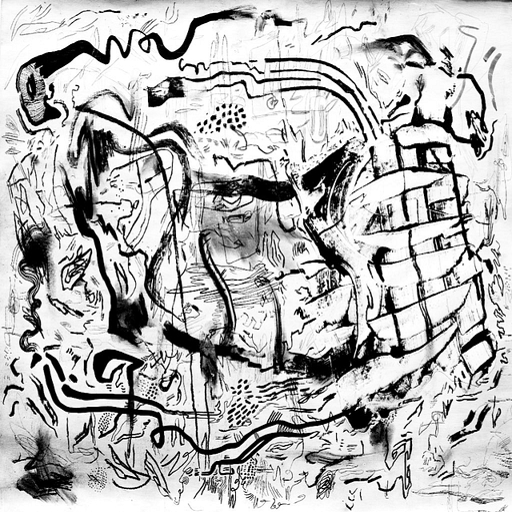

In [51]:
img = Image.open(os.path.join(data_path, str(test_img))).resize((512, 512))
img.show()

In [52]:
with torch.no_grad():
  img = transform(img).unsqueeze(0)
  encoded = model(img).squeeze().reshape(1, -1)

In [53]:
encoded.shape


torch.Size([1, 384])

In [54]:
# Query the index for the k most similar encodings to a given query encoding
k = 30
distances, indices = id_index.search(encoded.cpu(), k)


In [55]:
print(indices)

[[1035  677  152  152  152  413  172  172  172  667  918  232  232  232
   963  426  249  249  249   11   11   11   11  418  178  178  178 1189
   344  344]]


In [56]:
print(distances)

[[ 7906.9043  8331.212   8812.733   8812.733   8812.733   9369.607
   9570.955   9570.955   9570.955   9574.668   9606.492   9608.746
   9608.746   9608.746   9778.621   9827.848   9889.684   9889.684
   9889.684  10031.86   10031.86   10031.86   10031.86   10125.664
  10276.742  10276.742  10276.742  10561.066  10564.08   10564.08  ]]


OG SuperchiefNFT WORLDWIDE MULTI-PASS_0xa50dcd0bc755c3e59e49fa8a06db235f0118464d_1.jpeg


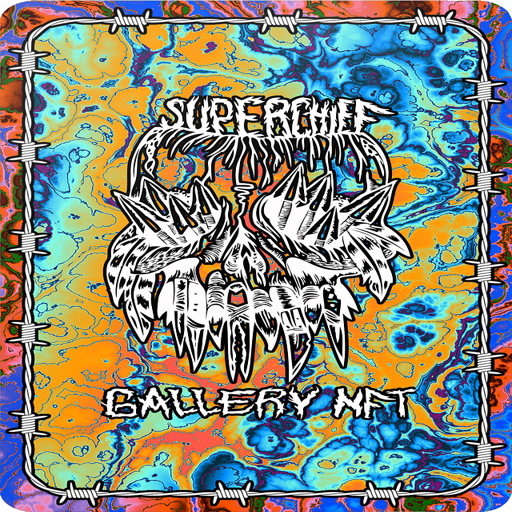

In [57]:
match_img = index_ids[indices[0][0]]
print(match_img)
img = Image.open(os.path.join(data_path, match_img)).resize((512, 512))
img

CryptoPepe #7_KT1RJ6PbjHpwc3M5rw5s2Nbmefwbuwbdxton_21268.jpeg


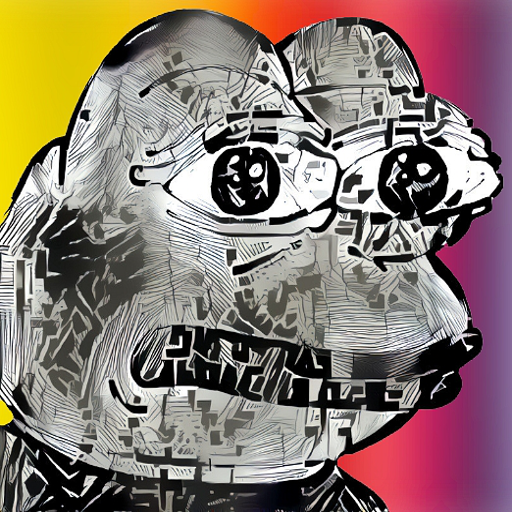

In [58]:
match_img = index_ids[indices[0][1]]
print(match_img)
img = Image.open(os.path.join(data_path, match_img)).resize((512, 512))
img

Vidyah The Librarian_0xffbc81170340cc12444615e14a39cc4240244a9c_3.jpeg


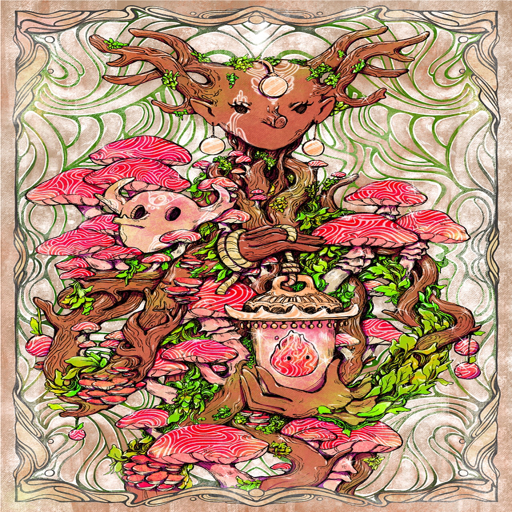

In [59]:
match_img = index_ids[indices[0][2]]
print(match_img)
img = Image.open(os.path.join(data_path, match_img)).resize((512, 512))
img

# New Section